<a href="https://www.kaggle.com/code/kawwie/neural-style-transfer?scriptVersionId=102055106" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from keras import layers, models

from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# **Initialize images**

In [17]:
base_img_link = "https://image.vietnamnews.vn/uploadvnnews/Article/2019/3/25/award98263136PM.jpg"
style_img_link = "https://upload.wikimedia.org/wikipedia/commons/6/63/Vincent_van_Gogh_-_Wheat_Field_with_Cypresses_-_Google_Art_Project.jpg"

img_height = 400
img_width = 400

base_image_path = keras.utils.get_file("base.jpg", origin=base_img_link)
style_reference_image_path = keras.utils.get_file("style.jpg",origin=style_img_link)


base_image = preprocess_img(base_image_path)
style_reference_image = preprocess_img(style_reference_image_path)





# **Initialize VGG19 model and layers**

In [11]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict) 

style_layer_names = [
 "block1_conv1",
 "block2_conv1",
 "block3_conv1",
 "block4_conv1",
 "block5_conv1",
]
content_layer_name = "block5_conv2"


80150528/80134624 [==============================] - 3s 0us/step


# **Preprocessing functions to feed images into VGG19**

In [6]:
def preprocess_img(img_path):
    img = keras.utils.load_img(img_path, target_size = (img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def preprocess_frame(frame):
    frame = cv.resize(frame , (img_width, img_height))
    frame = np.expand_dims(frame, axis = 0)
    frame = keras.applications.vgg19.preprocess_input(frame)
    return frame    

def deprocess_img(img):
    img = img.reshape((img_height, img_width, 3))
    img[:,:,0] += 103.939 
    img[:,:,1] += 116.779 
    img[:,:,2] += 123.68 
    img = img[:,:,::-1] 
    img = np.clip(img, 0, 255).astype("uint8")
    return img
    


# **Define loss functions**

In [7]:


def content_loss(base_img , combination_img):
    return 0.5 * tf.reduce_sum(tf.square(combination_img - base_img))
def gram_matrix(x):
    x = tf.transpose(x, (2,0,1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


def compute_loss(combination_image, base_image , style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis = 0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape = ())
    
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0,:,:,:]
    combination_features = layer_features[2,:,:,:]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    
    for layer_name in style_layer_names :
        layer_features = features[layer_name]
        style_reference_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        style_loss_value = style_loss(
            style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value
        
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image, model = False):
    with tf.GradientTape() as tape:     
        loss = compute_loss(combination_image, base_image, style_reference_image)
        grads = tape.gradient(loss, combination_image)
    return loss, grads



# **Image transform network architecture**

In [4]:
def upsamplingConv2d(x, upsampling_size, filters, kernel_size, strides):
    x = layers.UpSampling2D(upsampling_size, interpolation = "nearest")(x)
    p = kernel_size // 2
    out = tf.pad(x, paddings=[[0,0], [p, p], [p , p], [0,0]], mode='REFLECT')
    out = layers.Conv2D(filters, kernel_size, strides)(out)
    out = InstanceNormalization()(out)
    out = layers.ReLU()(out)
    return out 


def resblock(x, filters, kernel_size , stride):
    fx = convLayer(x, filters, kernel_size, strides = stride)
    fx = InstanceNormalization()(fx)
    fx = layers.ReLU()(fx)
    fx = convLayer(fx, filters, kernel_size, strides = stride)
    fx = InstanceNormalization()(fx)
    
    out = layers.Add()([x,fx])
    return out




def convLayer(x,filters, kernel_size, strides):
    p = kernel_size // 2
    out = tf.pad(x, paddings=[[0,0], [p, p], [p , p], [0,0]], mode='REFLECT')
    out = layers.Conv2D(filters,kernel_size, strides)(out)
    return out

inputs = keras.Input(shape = (img_height,img_width,3))
conv1 = convLayer(inputs, filters = 32,kernel_size = 9, strides = 1)
in1 = InstanceNormalization()(conv1)
r1 = layers.ReLU()(in1)
conv2 = convLayer(r1, 64,kernel_size = 3, strides = 2)
in2 = InstanceNormalization()(conv2)
r2 = layers.ReLU()(in2)
conv3 = convLayer(r2, 128,kernel_size = 3, strides = 2)
in3 = InstanceNormalization()(conv3)
r3 = layers.ReLU()(in3)

res1 = resblock(r3, 128,3,1)
res2 = resblock(res1, 128 , 3 , 1)
res3 = resblock(res2, 128 , 3 , 1)
res4 = resblock(res3, 128 , 3 , 1)
res5 = resblock(res4, 128 , 3 , 1)

deconv1 = upsamplingConv2d(res5,(2,2), 64 , 3 , 1)
deconv2 = upsamplingConv2d(deconv1, (2,2), 32, 3 , 1)
out = convLayer(deconv2, 3, kernel_size = 9, strides = 1)

transformers_model = keras.Model(inputs=inputs, outputs=out)


def visualize_model():
    keras.utils.plot_model(transformers_model, show_shapes=True)





2022-07-29 14:56:14.680314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:56:14.798666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:56:14.799527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:56:14.801287: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# **Initialize dataset**

In [ ]:
dataset = image_dataset_from_directory('../input/coco-2017-dataset/coco2017/train2017', labels = None, batch_size = 1, image_size = (img_height, img_width))


# **Training image transform net**

In [ ]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-6

optimizer = keras.optimizers.Adam()


@tf.function
def train_step(x):
    preprocessed_x = keras.applications.vgg19.preprocess_input(x)
    with tf.GradientTape() as tape:
        combination_images = transformers_model(preprocessed_x, training = True)
        loss = compute_loss(combination_images, preprocessed_x, style_reference_image)
    grads = tape.gradient(loss,transformers_model.trainable_weights)

    optimizer.apply_gradients(zip(grads, transformers_model.trainable_weights))
    return loss


epochs = 1
for epoch in range(epochs):
    for step, x in enumerate(dataset):
        loss = train_step(x)
        if(step % 200 == 0):
            print(f"Epoch {epoch}, step {step}: loss={loss:.2f}")
            
    

# **Apply style directly on Image**

In [12]:

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8 

combination_image = tf.Variable(preprocess_img(base_image_path))

iterations = 1000


optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps = 100, decay_rate = 0.96
    )
)

images = []
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0 :
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_img(combination_image.numpy())
        images.append(img)
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)


2022-07-29 14:58:30.757319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-29 14:58:32.023444: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Iteration 100: loss=3934.33
Iteration 200: loss=2797.84
Iteration 300: loss=2421.47
Iteration 400: loss=2232.89
Iteration 500: loss=2117.63
Iteration 600: loss=2038.04
Iteration 700: loss=1978.97
Iteration 800: loss=1932.95
Iteration 900: loss=1895.86
Iteration 1000: loss=1864.97


# **Visualize convolution layer activations**

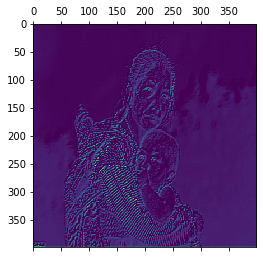

In [14]:
layer_index = 2

layer_outputs = []
for layer in model.layers:
    layer_outputs.append(layer.output)
activation_model = keras.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(preprocess_img(base_image_path))

layer_activation = activations[2]
plt.matshow(layer_activation[0, :, :, 1])